In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings("ignore") 

df = pd.read_csv('.\\WineQT.csv')

df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
       fixed acidity  volatile acidity  citric acid  residual sugar  \
coun

In [2]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


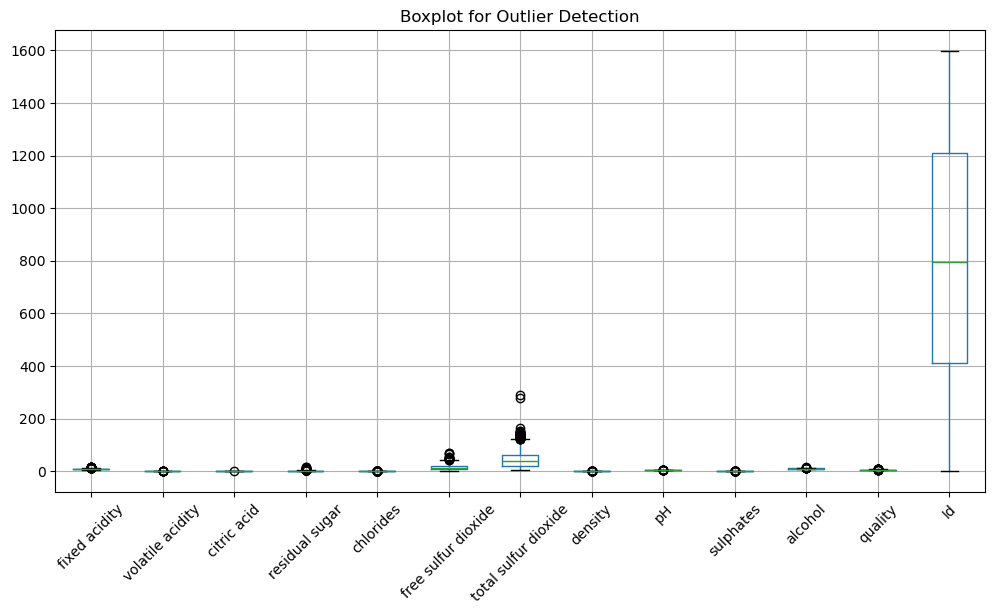

Shape before removing outliers: (1143, 13)


In [3]:
# Handling missing values (if any)
df.dropna(inplace=True)

# Checking for outliers using boxplots
plt.figure(figsize=(12,6))
df.boxplot(rot=45)
plt.title('Boxplot for Outlier Detection')
plt.show()
print("Shape before removing outliers:", df.shape)

In [4]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df = df[~outlier_mask.any(axis=1)]

df_cleaned = df[~outlier_mask.any(axis=1)]
print("Shape after removing outliers:", df_cleaned.shape)

Shape after removing outliers: (834, 13)


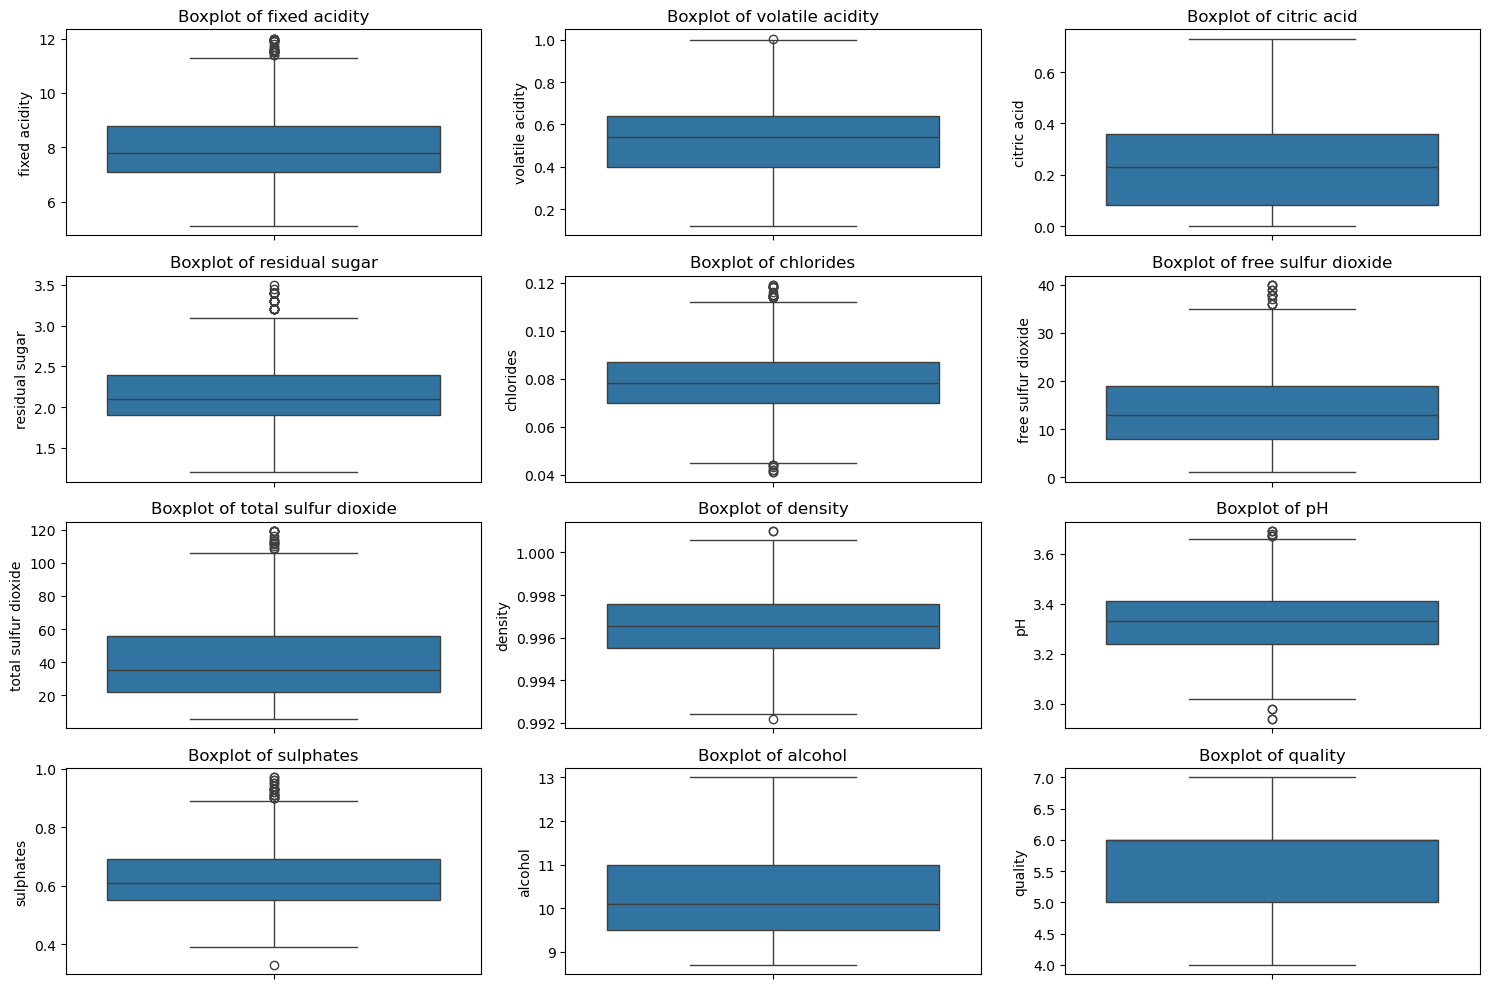

In [5]:
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]  # Removes rows where any feature has a z-score > 3
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):  # Exclude quality column
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()



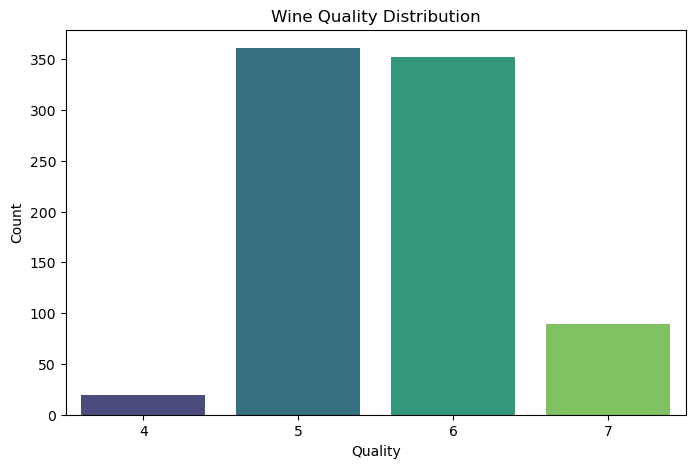

In [6]:
# Visualizing class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Wine Quality Distribution')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

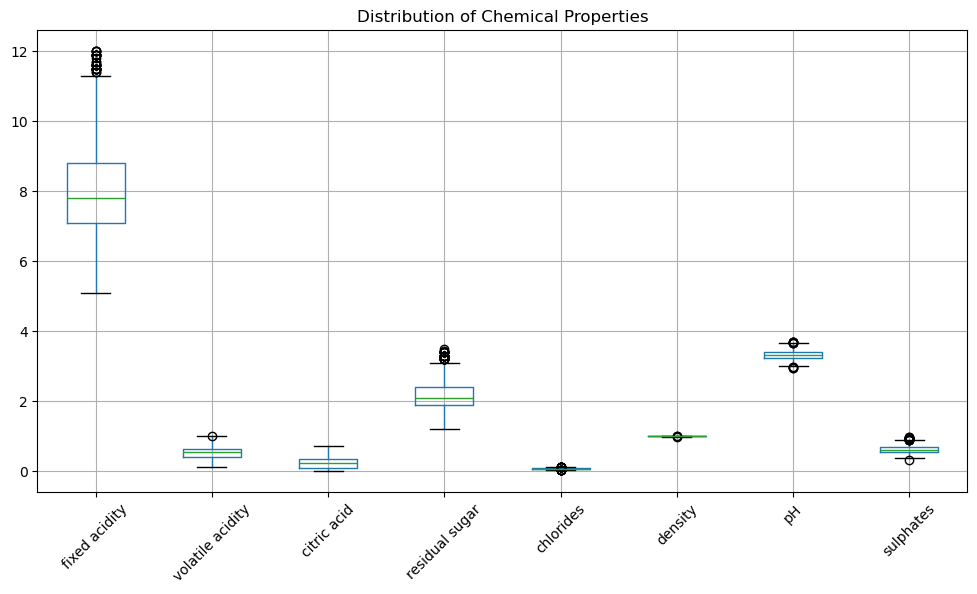

In [7]:
# Analyzing chemical properties of wine
chemical_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                     'chlorides', 'density', 'pH', 'sulphates']
plt.figure(figsize=(12,6))
df[chemical_features].boxplot(rot=45)
plt.title('Distribution of Chemical Properties')
plt.show()

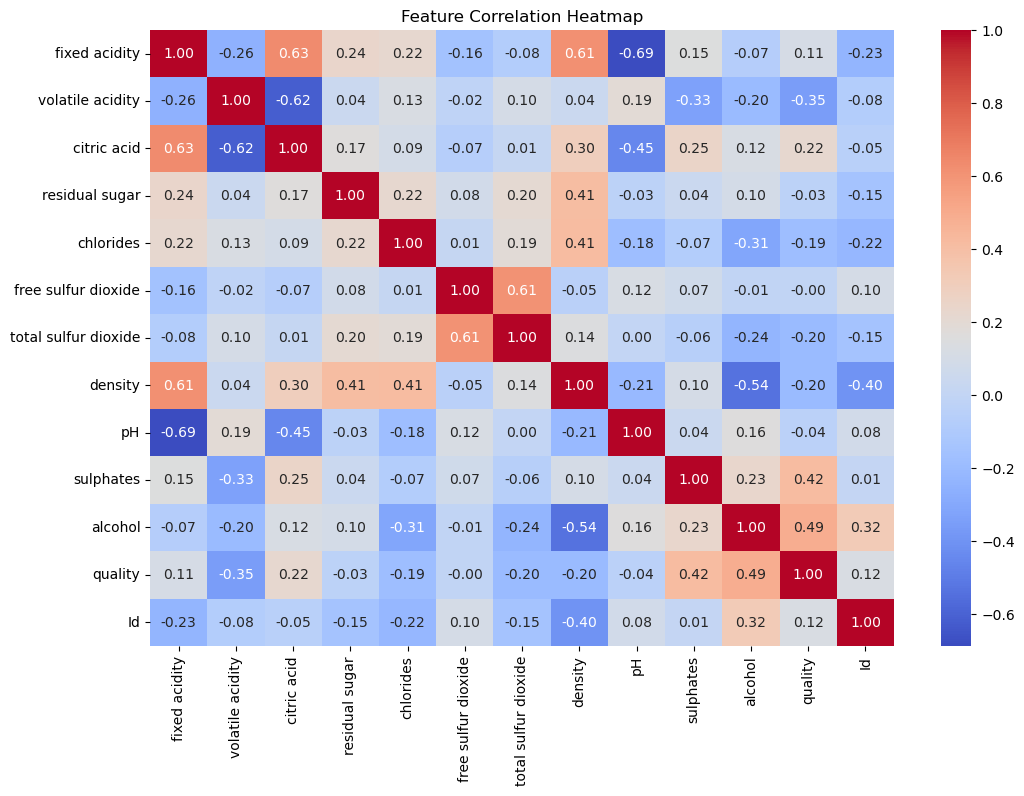

In [8]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [9]:
# Feature Selection
X = df.drop(['quality', 'Id'], axis=1)  # Drop unnecessary columns
y = df['quality']

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training with Hyperparameter Tuning
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='accuracy')
rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [10]:
# Training classifiers
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SGD Classifier': SGDClassifier(random_state=42),
    'SVC': SVC()
}
import warnings
warnings.simplefilter('ignore')  # Suppress all warnings

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'\n{name} Performance:')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=1))  # Suppress warning
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))



Random Forest Performance:
Accuracy: 0.8027681660899654
Classification Report:
               precision    recall  f1-score   support

           4       0.97      0.97      0.97        72
           5       0.68      0.75      0.71        72
           6       0.68      0.55      0.61        73
           7       0.87      0.94      0.91        72

    accuracy                           0.80       289
   macro avg       0.80      0.80      0.80       289
weighted avg       0.80      0.80      0.80       289

Confusion Matrix:
 [[70  2  0  0]
 [ 1 54 15  2]
 [ 1 24 40  8]
 [ 0  0  4 68]]

SGD Classifier Performance:
Accuracy: 0.5467128027681661
Classification Report:
               precision    recall  f1-score   support

           4       0.58      0.76      0.66        72
           5       0.48      0.44      0.46        72
           6       0.37      0.23      0.29        73
           7       0.67      0.75      0.71        72

    accuracy                           0.55       


Random Forest Performance:
Accuracy: 0.7889273356401384
Classification Report:
               precision    recall  f1-score   support

           4       0.97      0.97      0.97        72
           5       0.66      0.74      0.70        72
           6       0.65      0.51      0.57        73
           7       0.85      0.94      0.89        72

    accuracy                           0.79       289
   macro avg       0.78      0.79      0.78       289
weighted avg       0.78      0.79      0.78       289



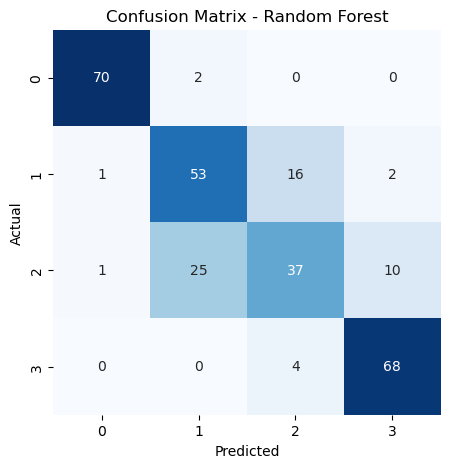


SGD Classifier Performance:
Accuracy: 0.5467128027681661
Classification Report:
               precision    recall  f1-score   support

           4       0.58      0.76      0.66        72
           5       0.48      0.44      0.46        72
           6       0.37      0.23      0.29        73
           7       0.67      0.75      0.71        72

    accuracy                           0.55       289
   macro avg       0.52      0.55      0.53       289
weighted avg       0.52      0.55      0.53       289



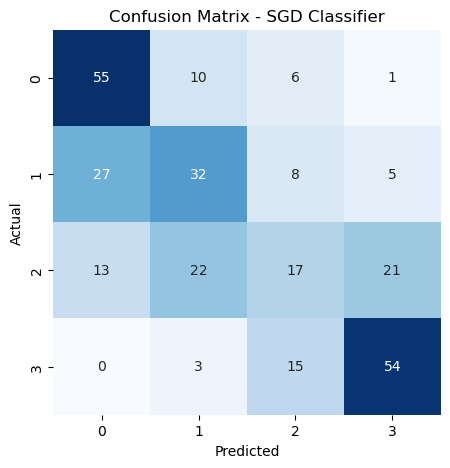


SVC Performance:
Accuracy: 0.7716262975778547
Classification Report:
               precision    recall  f1-score   support

           4       0.87      1.00      0.93        72
           5       0.67      0.64      0.65        72
           6       0.64      0.56      0.60        73
           7       0.88      0.89      0.88        72

    accuracy                           0.77       289
   macro avg       0.76      0.77      0.77       289
weighted avg       0.76      0.77      0.77       289



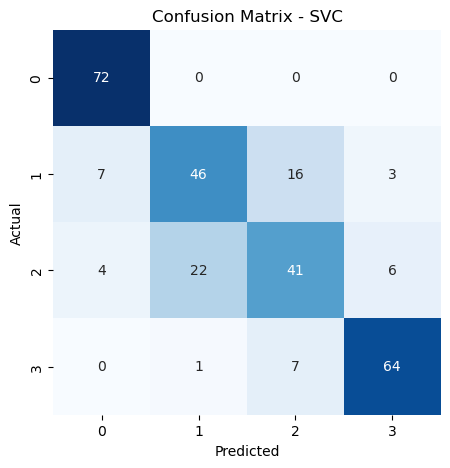

In [11]:
# Training other models
models = {
    'Random Forest': rf.best_estimator_,
    'SGD Classifier': SGDClassifier(random_state=42),
    'SVC': SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'\n{name} Performance:')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix Visualization
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


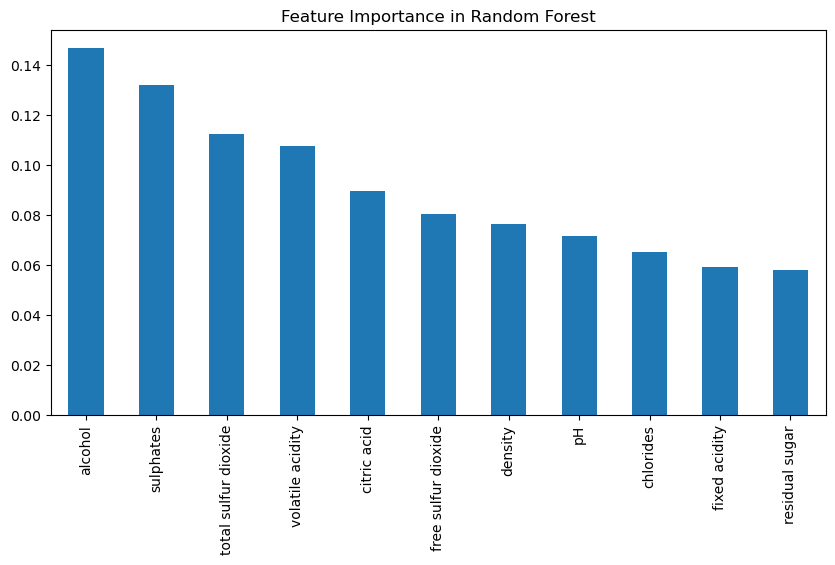

In [12]:
# Feature Importance Analysis
rf_best = models['Random Forest']
feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title('Feature Importance in Random Forest')
plt.show()